<a href="https://colab.research.google.com/github/kostarakonjac1331/AE-C-network/blob/main/AE%26C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORTOVI


In [41]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets
from tensorflow.keras.models import  Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose,Dense,LeakyReLU,BatchNormalization,Dropout,Input,MaxPool2D,Flatten,Activation

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import itertools

In [2]:
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

#KONVOLUCIONI AUTOENCODER

Autoenkoderi sluze za kompresovanje i dekompresovanje podataka. Mozemo ih koristiti za skidanje suma sa slika, detekciju anomalija, kompresiju podataka za velike fajlove koje zelimo da skinemo, koji se posle dekompresuju na nasem uredjaju. Autoenkoderi se sastoje iz dva dela: enkoder (deo koji je zasluzan za kompresovanje podataka) i dekoder(deo koji je zasluzan za dekompresovanje podataka). U nasem slucaju nas enkoder se sastoji iz 2d konvolucionih slojeva i leakyReLu aktivacione funkcije sa padom od 0.001. Kada se prodje jedan konvolucioni sloj smanjuje se velicina slika za 2 puta. Dekoder se sastoji od 2d transponovanih konvolucionih slojeva i LeakyReLu aktivacija koje imaju isti pad kao i u enkoderu. 2d transponovani konvolucioni slojevi sluze za povecavanje dimenzija nase kompresovane slike i vracanje izgleda u prvobitno stanje. Na kraju imamo jedan 2d konvolucioni sloj koji sluzi da vratimo originalni oblik slike.




In [3]:
class AutoEncoder(Model):
  def __init__(self,input_shape):
    super(AutoEncoder,self).__init__()
    #encoder mreza
    self.encoder = keras.Sequential([
      Input(shape=input_shape),
      Conv2D(64,kernel_size=3,strides=2,padding='same'),
      LeakyReLU(0.001),
      Conv2D(64,kernel_size=3,strides=2,padding='same'),
      LeakyReLU(0.001)
    ])

    #decoder mreza
    self.decoder = keras.Sequential([
      Conv2DTranspose(64,kernel_size=3,strides=2,padding='same'),
      LeakyReLU(0.001),
      Conv2DTranspose(64,kernel_size=3,strides=2,padding='same'),
      LeakyReLU(0.001),
      Conv2D(input_shape[2],kernel_size=3,padding='same'),
      LeakyReLU(0.001)
    ])

  def call(self,x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded




#KONVOLUCIONI KLASIFIKATOR

Nasa neuronska mreza za klasifikaciju se sastoji od 4 ciklusa 2d konvolucionih slojeva sa LeakyRelu aktivacijom ciji je pad 0.2. Posle svakog konvolucionog sloja imamo i dropout od 20%. Posle flatten sloja imamo guste slojeve koji takodje kao aktivacionu funkciju korste LeakyReLu ali imaju i sloj za batch normalizaciju. Batch normalizaciju koristimo za ubrzavanje ucenja nase mreze tako sto cemo normalizovati inpute nasih slojeva. Ovu mrezu smo kreirali pomocu keras subclassing api-a.

In [4]:
class CNNClasificator(Model):
  def __init__(self,number_of_classes):
    super(CNNClasificator,self).__init__()
    self.conv1 = Conv2D(16,kernel_size=3,padding='same')
    self.leaky1 = LeakyReLU(0.2)
    self.maxP1 = MaxPool2D()
    self.drop1 = Dropout(0.2)

    self.conv2 = Conv2D(32,kernel_size=3,padding='same')
    self.leaky2 = LeakyReLU(0.2)
    self.maxP2 = MaxPool2D()
    self.drop2 = Dropout(0.2)

    self.conv3 = Conv2D(64,kernel_size=3,padding='same')
    self.leaky3 = LeakyReLU(0.2)
    self.maxP3 = MaxPool2D()
    self.drop3 = Dropout(0.2)

    self.conv4 = Conv2D(128,kernel_size=3,padding='same')
    self.leaky4 = LeakyReLU(0.2)
    self.maxP4 = MaxPool2D()
    self.drop4 = Dropout(0.3)

    self.flat = Flatten()

    self.dense1 = Dense(512)
    self.leaky5 = LeakyReLU(0.2)
    self.drop5 = Dropout(0.3)
    self.batch1 = BatchNormalization()

    self.dense2 = Dense(128)
    self.leaky6 = LeakyReLU(0.2)
    self.drop6 = Dropout(0.3)
    self.batch2 = BatchNormalization()

    self.dense3 = Dense(64)
    self.leaky7 = LeakyReLU(0.2)
    self.drop7 = Dropout(0.2)
    self.batch3 = BatchNormalization()

    self.dense4 = Dense(number_of_classes)

  def call(self,x):
    x = self.leaky1(self.conv1(x))
    x = self.maxP1(x)
    x = self.drop1(x)

    x = self.leaky2(self.conv2(x))
    x = self.maxP2(x)
    x = self.drop2(x)

    x = self.leaky3(self.conv3(x))
    x = self.maxP3(x)
    x = self.drop3(x)

    x = self.leaky4(self.conv4(x))
    x = self.maxP4(x)
    x = self.drop4(x)

    x = self.flat(x)

    x = self.leaky5(self.dense1(x))
    x = self.drop5(x)
    x = self.batch1(x)

    x = self.leaky6(self.dense2(x))
    x = self.drop6(x)
    x = self.batch2(x)

    x = self.leaky7(self.dense3(x))
    x = self.drop7(x)
    x = self.batch3(x)

    x = self.dense4(x)

    return x



#AEC

Ova klasa sluzi kako bi objedinila autoenkoder i klasifikator. Za instanciranje ove klase potrebno je proslediti parametre za dataset koji zelimo da koristimo, dataset sa sumom za nas autoenkoder, oblikom naseg inputa i klasama naseg dataseta. Funkcije koja ova klasa ima su:

<li>Treniranje autoenkodera: <b>trainAutoEncoder()</b></li>
<li>Treniranje klasifikatora: <b>trainClasificator()</b></li>
<li>Skidanje suma sa slike: <b>encodingDecoding()</b></li>
<li>Predikcija klasifikatora: <b>clasifierPredict()</b></li>
<li>Prikazivanje prosecne greske klasifikatora: <b>plotLoss()</b></li>
<li>Prikazivanje preciznosti klasifikatora: <b>plotAccuracy()</b></li>
<li>Prikazivanje matrice konfuzije za nas klasifikator: <b>plot_confusion_matrix()</b></li>

In [5]:
class AEC:
  def __init__(self,train_data,test_data,train_labels,test_labels,noisy_train,noisy_test,input_shape,classes):
    self.train_data = train_data
    self.test_data = test_data
    self.train_labels = train_labels
    self.test_labels = test_labels
    self.noisy_test = noisy_test
    self.noisy_train = noisy_train
    self.classes = classes
    self.autoencoder = AutoEncoder(input_shape)
    self.clasificator = CNNClasificator(len(classes))
    self.history = None
    self.predictions = None
  

  def trainAutoEncoder(self):
    self.autoencoder.compile(optimizer='adam',loss=keras.losses.MeanSquaredError())

    self.autoencoder.fit(self.noisy_train, self.train_data,
                epochs=10,
                shuffle=True,
                validation_data=(self.noisy_test, self.test_data))
    print(self.autoencoder.encoder.summary())
    print(self.autoencoder.decoder.summary())

    print("rezultat treniranja: \n")
    encoded_imgs = model.autoencoder.encoder(x_test).numpy()
    decoded_imgs = model.autoencoder.decoder(encoded_imgs).numpy()
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):

      ax = plt.subplot(2, n, i + 1)
      plt.title("original")
      plt.imshow(tf.squeeze(x_test_noisy[i]))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      bx = plt.subplot(2, n, i + n + 1)
      plt.title("rekonstruisana")
      plt.imshow(tf.squeeze(decoded_imgs[i]))
      plt.gray()
      bx.get_xaxis().set_visible(False)
      bx.get_yaxis().set_visible(False)
      
    plt.show()


  def trainClasificator(self):
    self.clasificator.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(lr=3e-4),
    metrics=["accuracy"],
    )
    self.history = self.clasificator.fit(self.train_data, self.train_labels, batch_size=64, epochs=50, verbose=2,validation_data=(self.test_data,self.test_labels))
    self.predictions = np.argmax(self.clasificator.predict(x=self.test_data, batch_size=64, verbose=0),axis=1)

  def clasifierPredict(self,picture):
    picture = tf.expand_dims(input=picture,axis=0)
    predikcija = self.clasificator.predict(x=picture,batch_size=64)
    roundPredikcija = np.argmax(predikcija)
    return roundPredikcija

  def plotAccuracy(self):
    plt.plot(self.history.history['accuracy'], label='accuracy')
    plt.plot(self.history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')
  
  def plotLoss(self):
    plt.plot(self.history.history['loss'], label='loss')
    plt.plot(self.history.history['val_loss'], label = 'val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([0, 3])
    plt.legend(loc='lower right')

    test_loss, test_acc = self.clasificator.evaluate(self.test_data, self.test_labels, verbose=2)


  def plot_confusion_matrix(self,target_names,title='Matrica konfuzije',cmap=None,normalize=True):
    cm = confusion_matrix(y_true=self.test_labels, y_pred=self.predictions)
    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
      cmap = plt.get_cmap('magma')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
      tick_marks = np.arange(len(target_names))
      plt.xticks(tick_marks, target_names, rotation=45)
      plt.yticks(tick_marks, target_names)

    if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thtest_labelsresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      if normalize:
        plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                horizontalalignment="center",
                color="red")
      else:
        plt.text(j, i, "{:,}".format(cm[i, j]),
                horizontalalignment="center",
                color="red")


    plt.tight_layout()
    plt.ylabel('Tacne klase')
    plt.xlabel('Prediktovane klase\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()


  def encodingDecoding(self,picture):
    picture = tf.expand_dims(input = picture, axis = 0)
    enc = self.autoencoder.encoder(picture)
    dec = self.autoencoder.decoder(enc)

    return dec

    

#Ucitavanje prvog dataseta: CIFAR10

Cifar10 se sastoji od 60000 slika koje su dimenzija 32X32 sa 3 color channela.

In [6]:
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()
x_train = x_train.astype("float32") /255.0
x_test = x_test.astype("float32") / 255.0

noise_factor = 0.15
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape) 

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

x_test.shape

(10000, 32, 32, 3)

#Klase CIFAR10 dataseta

In [7]:
classNames = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

Epoch 1/10
1563/1563 [==============================] - 14s 7ms/step - loss: 0.0151 - val_loss: 0.0032
Epoch 2/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.0032 - val_loss: 0.0030
Epoch 3/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 4/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 5/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 6/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 7/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 8/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 9/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 10/10
1563/1563 [==============================] - 10s 6ms/step - l

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


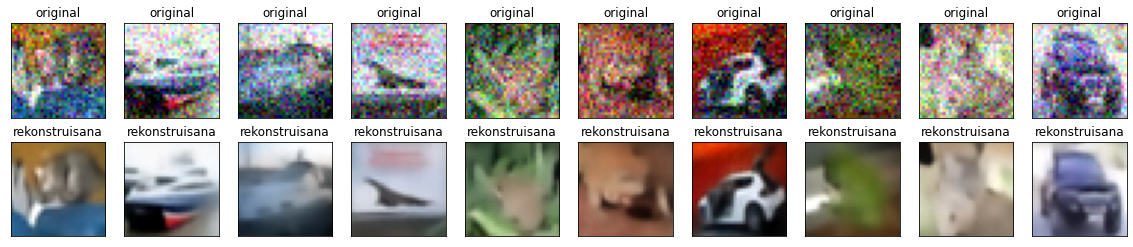

In [8]:
model = AEC(x_train,x_test,y_train,y_test,x_train_noisy,x_test_noisy,classes=classNames,input_shape=(32,32,3))
model.trainAutoEncoder()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


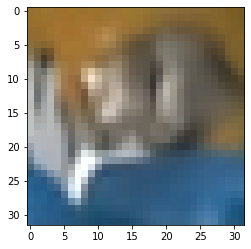

In [9]:
dc = model.encodingDecoding(x_test[0])
plt.imshow(tf.squeeze(dc))


In [10]:
model.trainClasificator()

Epoch 1/50
782/782 - 6s - loss: 2.1246 - accuracy: 0.2531 - val_loss: 1.8346 - val_accuracy: 0.3227
Epoch 2/50
782/782 - 4s - loss: 1.6307 - accuracy: 0.3957 - val_loss: 1.6958 - val_accuracy: 0.3837
Epoch 3/50
782/782 - 4s - loss: 1.4577 - accuracy: 0.4680 - val_loss: 1.7340 - val_accuracy: 0.4143
Epoch 4/50
782/782 - 4s - loss: 1.3466 - accuracy: 0.5143 - val_loss: 1.2131 - val_accuracy: 0.5630
Epoch 5/50
782/782 - 4s - loss: 1.2657 - accuracy: 0.5438 - val_loss: 1.1811 - val_accuracy: 0.5780
Epoch 6/50
782/782 - 4s - loss: 1.2014 - accuracy: 0.5703 - val_loss: 1.0774 - val_accuracy: 0.6160
Epoch 7/50
782/782 - 4s - loss: 1.1438 - accuracy: 0.5947 - val_loss: 1.0919 - val_accuracy: 0.6116
Epoch 8/50
782/782 - 4s - loss: 1.0999 - accuracy: 0.6113 - val_loss: 1.0558 - val_accuracy: 0.6278
Epoch 9/50
782/782 - 4s - loss: 1.0571 - accuracy: 0.6280 - val_loss: 0.9687 - val_accuracy: 0.6533
Epoch 10/50
782/782 - 4s - loss: 1.0219 - accuracy: 0.6406 - val_loss: 0.9161 - val_accuracy: 0.6727

In [11]:
print(x_test[0].size)

3072


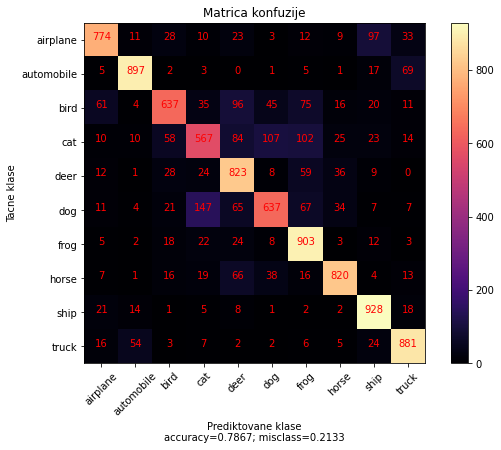

In [12]:
model.plot_confusion_matrix(target_names=classNames, title="Matrica konfuzije", normalize=False)

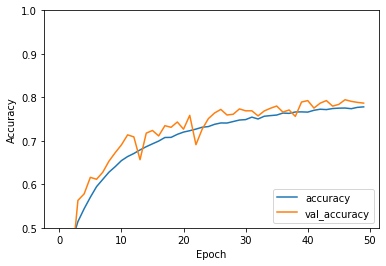

In [13]:
model.plotAccuracy()

313/313 - 1s - loss: 0.6104 - accuracy: 0.7867


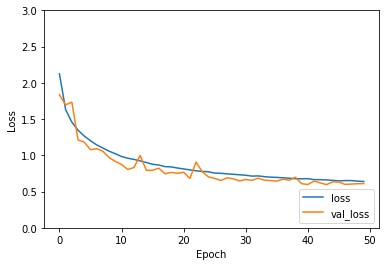

In [14]:
model.plotLoss()

#Prikaz procenta tacnosti klasifikatora pre preciscavanja slika

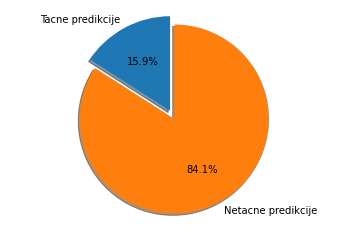

In [15]:
broj_tacnih_predikcija_noisy = 0


counter = 0
for i in range(int(x_test.size/x_test[0].size)):
  predikcija = model.clasifierPredict(x_test_noisy[i])
  if(predikcija == y_test[i]):
    broj_tacnih_predikcija_noisy+=1
    
procenat_tacnosti = broj_tacnih_predikcija_noisy/y_test.size

labels = 'Tacne predikcije', 'Netacne predikcije'
sizes = [procenat_tacnosti*100. ,(1-procenat_tacnosti)*100]
explode = (0, 0.1)  

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode = explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()


#Prikaz procenta tacnosti klasifikatora posle preciscavanja slika

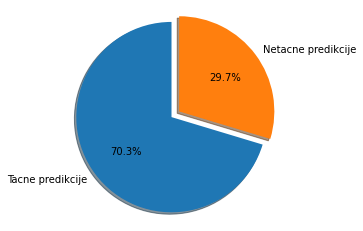

In [16]:
broj_tacnih_predikcija = 0



counter = 0
for i in range(int(x_test.size/x_test[0].size)):
  predikcija = model.clasifierPredict(tf.squeeze(model.encodingDecoding(x_test_noisy[i])))
  if(predikcija == y_test[i]):
    broj_tacnih_predikcija+=1
    
procenat_tacnosti = broj_tacnih_predikcija/y_test.size

labels = 'Tacne predikcije', 'Netacne predikcije'
sizes = [procenat_tacnosti*100. ,(1-procenat_tacnosti)*100]
explode = (0, 0.1)  

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()



#Ucitavanje drugog dataseta: FASHON MNIST

Fashon mnist dataset se sastoji od 60000 slika koje su dimenzija 28X28 sa jednim color channelom.

In [17]:
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()
x_train = x_train.astype("float32") /255.0
x_test = x_test.astype("float32") / 255.0

x_train = tf.expand_dims(input = x_train,axis = 3)
x_test = tf.expand_dims(input = x_test,axis = 3)

noise_factor = 0.15
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape) 

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

x_test.shape

TensorShape([10000, 28, 28, 1])

#Klase fashon mnist dataseta

In [18]:
class_names = ["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]


Epoch 1/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0133 - val_loss: 0.0038
Epoch 2/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0037 - val_loss: 0.0035
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 4/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 5/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 6/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 7/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0032 - val_loss: 0.0033
Epoch 8/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0032 - val_loss: 0.0033
Epoch 9/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 10/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.003

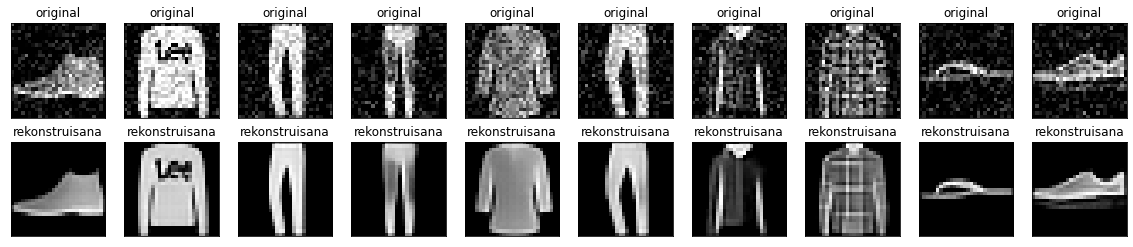

In [19]:
model = AEC(x_train,x_test,y_train,y_test,x_train_noisy,x_test_noisy,classes=class_names,input_shape=(28,28,1))
model.trainAutoEncoder()

In [20]:
model.trainClasificator()

Epoch 1/50
938/938 - 7s - loss: 1.1278 - accuracy: 0.5934 - val_loss: 0.5725 - val_accuracy: 0.7775
Epoch 2/50
938/938 - 5s - loss: 0.6254 - accuracy: 0.7697 - val_loss: 0.4547 - val_accuracy: 0.8308
Epoch 3/50
938/938 - 5s - loss: 0.5121 - accuracy: 0.8174 - val_loss: 0.3848 - val_accuracy: 0.8580
Epoch 4/50
938/938 - 5s - loss: 0.4499 - accuracy: 0.8409 - val_loss: 0.3491 - val_accuracy: 0.8695
Epoch 5/50
938/938 - 5s - loss: 0.4131 - accuracy: 0.8534 - val_loss: 0.3276 - val_accuracy: 0.8781
Epoch 6/50
938/938 - 5s - loss: 0.3841 - accuracy: 0.8637 - val_loss: 0.3084 - val_accuracy: 0.8843
Epoch 7/50
938/938 - 5s - loss: 0.3650 - accuracy: 0.8705 - val_loss: 0.2964 - val_accuracy: 0.8914
Epoch 8/50
938/938 - 5s - loss: 0.3440 - accuracy: 0.8778 - val_loss: 0.2930 - val_accuracy: 0.8929
Epoch 9/50
938/938 - 5s - loss: 0.3362 - accuracy: 0.8800 - val_loss: 0.2782 - val_accuracy: 0.8973
Epoch 10/50
938/938 - 5s - loss: 0.3241 - accuracy: 0.8860 - val_loss: 0.2718 - val_accuracy: 0.9006

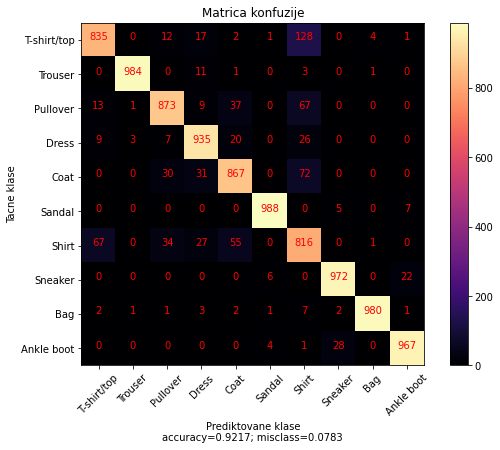

In [21]:
model.plot_confusion_matrix(target_names=class_names, title="Matrica konfuzije", normalize=False)

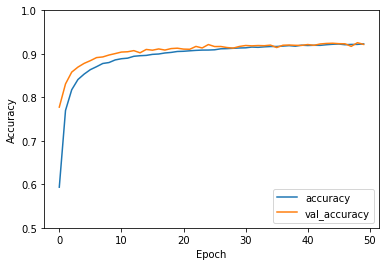

In [22]:
model.plotAccuracy()

313/313 - 1s - loss: 0.2147 - accuracy: 0.9217


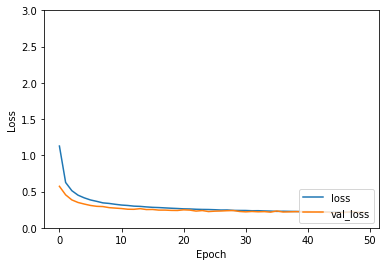

In [23]:
model.plotLoss()

In [24]:
len(x_test)

10000

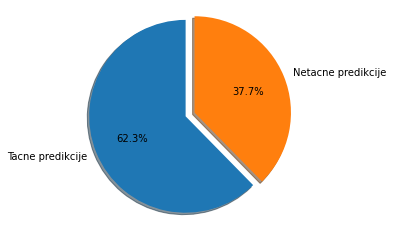

In [25]:
broj_tacnih_predikcija_noisy = 0


counter = 0
for i in range(len(x_test)):
  predikcija = model.clasifierPredict(x_test_noisy[i])
  if(predikcija == y_test[i]):
    broj_tacnih_predikcija_noisy+=1
    
procenat_tacnosti = broj_tacnih_predikcija_noisy/y_test.size

labels = 'Tacne predikcije', 'Netacne predikcije'
sizes = [procenat_tacnosti*100. ,(1-procenat_tacnosti)*100]
explode = (0,0.1)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode = explode , labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [32]:
x_test_noisy[0].shape


TensorShape([28, 28, 1])

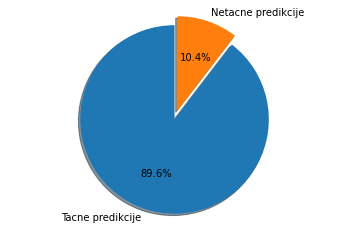

In [40]:
broj_tacnih_predikcija_noisy = 0


counter = 0
for i in range(len(x_test)):
  dc = tf.squeeze(model.encodingDecoding(x_test_noisy[i]))
  dc = tf.expand_dims(input=dc,axis=2)
  predikcija = model.clasifierPredict(dc)
  if(predikcija == y_test[i]):
    broj_tacnih_predikcija_noisy+=1
    
procenat_tacnosti = broj_tacnih_predikcija_noisy/y_test.size

labels = 'Tacne predikcije', 'Netacne predikcije'
sizes = [procenat_tacnosti*100. ,(1-procenat_tacnosti)*100]
explode = (0,0.1)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode = explode , labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()
